In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import division  # Python 2 users only
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords 
from sklearn.preprocessing import OneHotEncoder
from random import shuffle

In [2]:
# Introducing stopwords
stop_words = stopwords.words('english')
stop_words += ['p', 'em', 'nbsp', 'em','li', 'div', 'br', 
               'ul','ol','datacolumn','heading4','datalabel',
               'col','foa','row',
              '1396' , 'baghlan' , 'bphs', 'ephs', 'faryab',
               'kandahar', 'p160615', 'sehat', 'sehatmandi', 'xxx', 'eleven', 'ray']

In [3]:
df = pd.read_csv('Devex_train.csv', encoding='latin-1')

In [4]:
# # printing all labels
# print('Total number of labels =', len(df['Label 1'].unique()))
# print("_________________________________________________________")
# df['Label 2'].unique()
# labels1 = ['Label 1','Label 2','Label 3']
# label_meanings = []
# for x in labels1:
#     for y in df[x].unique():
#         label_meanings.append(y)
# set(label_meanings)

In [5]:
data = df.copy()
# lowercasing columns names
data.columns= data.columns.str.lower()

# removing spaces
data.columns = data.columns.str.replace(' ', '')


In [6]:
# fixing label column names
for index,y in data.iterrows():
    for x in range(12):
        if not pd.isna(data.iloc[index,x+3]):
            data.iloc[index,x+3] = (data.iloc[index,x+3][0:5])
            
data = data.iloc[:,:-2] # dropping last 2 columns, all null values

In [7]:
data['label1'].value_counts()

3.b.2    739
3.4.1    363
3.3.1    300
3.8.1    210
3.9.2    168
3.d.1    145
3.c.1    114
3.7.1    109
3.1.1    103
3.b.1     93
3.3.3     93
3.3.2     82
3.b.3     79
3.3.5     69
3.2.1     56
3.2.2     47
3.5.1     40
3.9.1     35
3.4.2     26
3.9.3     25
3.a.1     24
3.5.2     18
3.1.2     17
3.3.4     17
3.6.1     13
3.7.2      6
3.8.2      4
Name: label1, dtype: int64

In [8]:
len(data['label1'].value_counts())

27

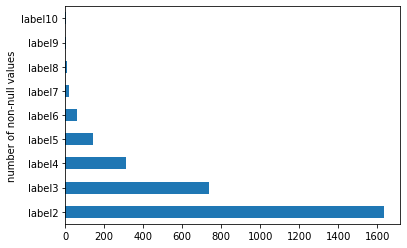

In [9]:
plt.ylabel('number of non-null values')
data.loc[:,'label2':'label10'].notnull().sum().plot(kind='barh');

In [10]:
# lowering the case of text
for index, y in data.iterrows():
    data.loc[index,'text'] = data.loc[index,'text'].lower()

In [11]:
# collating text
text = []
for x in data.loc[:,'text']:
    text.append(x)

In [12]:
# tokenizing text (splitting each word)
tokenizer = nltk.RegexpTokenizer(r"\w+")
data['tokens'] = '0'
for index in data.index:
    data.at[index,'tokens'] = tokenizer.tokenize(text[index])

In [13]:
# removing tokens that are in stopwords
for index in data.index:
    data.at[index,'tokens'] = [x for x in data.loc[index,'tokens'] if x not in stop_words]

In [14]:
# Freeing space
del tokenizer, df, stop_words

In [15]:

# list(nltk.bigrams(data['tokens'][0]))

In [16]:
# bgs = nltk.bigrams(data['tokens'][0])
# fdist = nltk.FreqDist(bgs)
# fdist.most_common(10)

# data['bigrams'] = '0'
# for 

In [17]:
# get dummies
data = data.join(data.loc[:,'label1':'label10'].stack().str.get_dummies().sum(level=0))

In [18]:
# creating another column to showcase number of labels
data['number_of_labels'] = 0
for index, y in data.iterrows():
    data.loc[index, 'number_of_labels'] = data.loc[index,'3.1.1':].sum()

<AxesSubplot:>

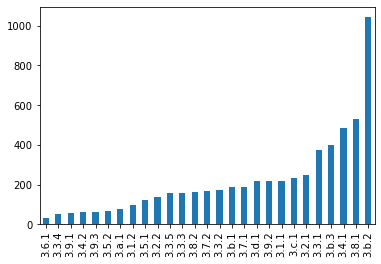

In [19]:
data.loc[:,'3.1.1':'3.d.1'].sum().sort_values().plot(kind = 'bar')

In [20]:
data.head()

,uniqueid,type,text,label1,label2,label3,label4,label5,label6,label7,...,3.9.1,3.9.2,3.9.3,3.a.1,3.b.1,3.b.2,3.b.3,3.c.1,3.d.1,number_of_labels
0,12555,Grant,centers of biomedical research excellence (cob...,3.b.2,3.c.1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,1,0,2
1,14108,Grant,research on regenerative medicine <h2><strong>...,3.b.2,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,1
2,23168,Organization,catholic health association of india (chai): <...,3.d.1,3.8.1,3.8.2,3.b.3,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,1,4
3,219512,Contract,quality improvement initiatives for diabetes,3.4.1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
4,274093,Tender,provision of thalassemia drugs and disposables...,3.3.5,3.4.1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,2


# Multi-Label Classification

In [21]:
# splitting token column by labels - each set of tokens will be associated with 
# its label
label_names = data.columns[14:-1]
full_corpus_tokens = {}
for label in label_names:
    temp = []
    for row_text in data[data[label] == 1]['tokens']:
        for each_word in row_text:
            temp.append(each_word)
    full_corpus_tokens[label] = temp
    
del temp,label

In [22]:
# function to convert tokens into tuple dictionaries for the classifier
def document_features(document, word_list):
    document_words = set(document) 
    features = {}
    for word in word_list:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [23]:
# getting most frequently occurred words by label. top 2000 words
top_words_by_label = {}

for label in label_names:
    top_words_by_label[label] = list(nltk.FreqDist(full_corpus_tokens[label]))[:2000]

In [24]:
# changing names of above only. nothing special. was getting confused. 
# ignore this code cell
word_features_by_label = {}
for label in label_names:
    word_features_by_label[label] = top_words_by_label[label]

In [25]:
# splitting tokens into is_label and not_label
# for example all tokens not in the 3.b.2 label will be different from 
# all labels not in 3.b.2
labeled_tokens_by_label = {}

for label in label_names:
    labeled_tokens = ([(tokens, label) for tokens in data[data[label] == 1].loc[:,'tokens']] +
                      [(tokens, 'not_' + label) for tokens in data[data[label] == 0].loc[:,'tokens']])
    shuffle(labeled_tokens)
    labeled_tokens_by_label[label] = labeled_tokens
    del(labeled_tokens)

# labeled_tokens = ([(tokens, '3.b.2') for tokens in data[data['3.b.2'] == 1].loc[:,'tokens']] +
#                   [(tokens, 'not_3.b.2') for tokens in data[data['3.b.2'] == 0].loc[:,'tokens']])

In [26]:
# for x in data['tokens']:
#     full_corpus_tokens += x

# all_words = list(nltk.FreqDist(full_corpus_tokens))[:5000]
# word_features = all_words
# full_corpus_tokens = []


In [27]:
featuresets_by_label = {}
train_set_by_label = {}
test_set_by_label = {}
classifier_by_label = {}

In [28]:
# this is where the magic happens
# making a seperate classifier for each label
for label in label_names:
    featuresets_by_label[label] = [(document_features(d, word_features_by_label[label]), c) for (d,c) in labeled_tokens_by_label[label]]
    
    train_set_by_label[label], test_set_by_label[label] = featuresets_by_label[label][100:], featuresets_by_label[label][:100]
    
    classifier_by_label[label] = nltk.NaiveBayesClassifier.train(train_set_by_label[label])

In [29]:
# creating a final set that i can compare our classifcation and true labels
final_featuresets_by_label = {}
for label in label_names:
    final_featuresets_by_label[label] = [(document_features(d, word_features_by_label[label]), 'whatever') for (d) in data.loc[:100,'tokens']]
# featuresets = [(document_features(d, word_features), c) for (d,c) in labeled_tokens]
# train_set, test_set = featuresets[100:], featuresets[:100]
# classifier = nltk.NaiveBayesClassifier.train(train_set)

In [30]:
del featuresets_by_label, train_set_by_label,  word_tokenize, word_features_by_label

In [31]:
accuracy_by_label = {}
for label in label_names:
    accuracy_by_label[label] = (nltk.classify.accuracy(classifier_by_label[label], test_set_by_label[label]))

In [32]:
sorted_accuracies = (sorted(accuracy_by_label.items(), key = lambda kv:(kv[1], kv[0])))  
print('(label, accuracy) --- number of texts for the label')
for i in sorted_accuracies:
    print(i,'  ---', data[i[0]].sum())

(label, accuracy) --- number of texts for the label
('3.d.1', 0.46)   --- 217
('3.8.1', 0.49)   --- 531
('3.7.2', 0.52)   --- 165
('3.7.1', 0.53)   --- 189
('3.9.2', 0.59)   --- 218
('3.3.3', 0.6)   --- 158
('3.b.3', 0.64)   --- 397
('3.3.2', 0.67)   --- 174
('3.3.5', 0.67)   --- 156
('3.c.1', 0.74)   --- 232
('3.2.2', 0.77)   --- 138
('3.9.1', 0.78)   --- 55
('3.b.2', 0.78)   --- 1044
('3.3.4', 0.82)   --- 53
('3.5.2', 0.82)   --- 68
('3.3.1', 0.83)   --- 372
('3.4.1', 0.86)   --- 485
('3.4.2', 0.86)   --- 61
('3.9.3', 0.86)   --- 63
('3.b.1', 0.86)   --- 185
('3.1.1', 0.87)   --- 218
('3.a.1', 0.87)   --- 76
('3.8.2', 0.89)   --- 161
('3.2.1', 0.91)   --- 249
('3.1.2', 0.92)   --- 97
('3.5.1', 0.93)   --- 123
('3.6.1', 0.93)   --- 33


In [33]:
#  '3.1.1 - Maternal mortality ratio' ,
#  '3.1.2 - Proportion of births attended by skilled health personnel',
#  '3.2.1 - Under-5 mortality rate',
#  '3.2.2 - Neonatal mortality rate',
#  '3.3.1 - Number of new HIV infections per 1,000 uninfected population, by sex, age and key populations',
#  '3.3.2 - Tuberculosis incidence per 100,000 population',
#  '3.3.3 - Malaria incidence per 1,000 population',
#  '3.3.4 - Hepatitis B incidence per 100,000 population',
#  '3.3.5 - Number of people requiring interventions against neglected tropical diseases',
#  '3.4.1 - Mortality rate attributed to cardiovascular disease, cancer, diabetes or chronic respiratory disease',
#  '3.4.2 - Suicide mortality rate',
#  '3.5.1 - Coverage of treatment interventions (pharmacological, psychosocial and rehabilitation and aftercare services) for substance use disorders',
#  '3.5.2 - Harmful use of alcohol, defined according to the national context as alcohol per capita consumption (aged 15 years and older) within a calendar year in litres of pure alcohol',
#  '3.6.1 - Death rate due to road traffic injuries',
#  '3.7.1 - Proportion of women of reproductive age (aged 15_49 years) who have their need for family planning satisfied with modern methods',
#  '3.7.2 - Adolescent birth rate (aged 10_14 years; aged 15_19 years) per 1,000 women in that age group',
#  '3.8.1 - Coverage of essential health services (defined as the average coverage of essential services based on tracer interventions that include reproductive, maternal, newborn and child health, infectious diseases, non-communicable diseases and service capacity and access, among the general and the most disadvantaged population)',
#  '3.8.2 - Proportion of population with large household expenditures on health as a share of total household expenditure or income',
#  '3.9.1 - Mortality rate attributed to household and ambient air pollution',
#  '3.9.2 - Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (exposure to unsafe Water, Sanitation and Hygiene for All (WASH) services)',
#  '3.9.3 - Mortality rate attributed to unintentional poisoning',
#  '3.a.1 - Age-standardized prevalence of current tobacco use among persons aged 15 years and older',
#  '3.b.1 - Proportion of the target population covered by all vaccines included in their national programme',
#  '3.b.2 - Total net official development assistance to medical research and basic health sector',
#  '3.b.3 - Proportion of health facilities that have a core set of relevant essential medicines available and affordable on a sustainable basis',
#  '3.c.1 - Health worker density and distribution',
#  '3.d.1 - International Health Regulations (IHR) capacity and health emergency preparedness',# 

In [34]:
classifier_by_label['3.b.2'].show_most_informative_features(20)

Most Informative Features
       contains(toolkit) = True            3.b.2 : not_3. =     42.9 : 1.0
     contains(drugabuse) = True            3.b.2 : not_3. =     31.7 : 1.0
      contains(neuronal) = True            3.b.2 : not_3. =     26.7 : 1.0
     contains(molecules) = True            3.b.2 : not_3. =     24.8 : 1.0
contains(braininitiative) = True            3.b.2 : not_3. =     21.8 : 1.0
           contains(nhs) = True            3.b.2 : not_3. =     19.5 : 1.0
          contains(adrd) = True            3.b.2 : not_3. =     19.3 : 1.0
          contains(nihr) = True            3.b.2 : not_3. =     19.3 : 1.0
           contains(cns) = True            3.b.2 : not_3. =     19.0 : 1.0
    contains(phenotypes) = True            3.b.2 : not_3. =     18.9 : 1.0
         contains(nacda) = True            3.b.2 : not_3. =     17.5 : 1.0
           contains(hta) = True            3.b.2 : not_3. =     16.1 : 1.0
    contains(commonfund) = True            3.b.2 : not_3. =     16.0 : 1.

In [50]:
row_number = 93
print('predicted labels for rownumber: {}'.format(row_number))
for label in label_names:
        if 'not' in classifier_by_label[label].classify(final_featuresets_by_label[label][row_number][0]):
            continue
        print(classifier_by_label[label].classify(final_featuresets_by_label[label][row_number][0]))

predicted labels for rownumber: 93
3.2.1
3.7.1
3.7.2


In [51]:
print('actual labels for rownumber: {}'.format(row_number))
for label in label_names:
    if data.loc[row_number,label] == 1:
        print(label)



actual labels for rownumber: 93
3.2.1
3.7.1
3.7.2


In [37]:
predicted_labels_by_row = {}
actual_labels_by_row = {}
for row in range(100):
    current_predictions = []
    current_actuals = []
    for label in label_names:
        if 'not' not in classifier_by_label[label].classify(final_featuresets_by_label[label][row][0]):
            current_predictions.append(classifier_by_label[label].classify(final_featuresets_by_label[label][row][0]))
        if data.loc[row,label] == 1:
            current_actuals.append(label)
    predicted_labels_by_row[row] = current_predictions
    actual_labels_by_row[row] = current_actuals

In [52]:
ultimate_accuracy = []
for i in range(100):
    length = len(actual_labels_by_row[i])
    qwe = 0
    for actual in actual_labels_by_row[i]:
        if actual in predicted_labels_by_row[i]:
            qwe += 1
    ultimate_accuracy.append(qwe/length)
sum(ultimate_accuracy)

63.333333333333336